# SpamData_LogisticRegression_Classifier

Author: Xin Zhengfang

## Data Preprocessing

In [1]:
import scipy.io as sio
import numpy as np

In [2]:
# Load .mat file into numpy array
mat_contents = sio.loadmat('spamData.mat')
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtrain', 'Xtest', 'ytrain', 'ytest'])

In [3]:
#  Convert to arrary
Xtrain = mat_contents['Xtrain']
Xtest = mat_contents['Xtest']
ytrain = mat_contents['ytrain']
ytest = mat_contents['ytest']
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(3065, 57) (1536, 57) (3065, 1) (1536, 1)


## Logistic Regression
**The class label:**
1. Because dataset has a lot of spam and non-spam emails, we don't need do some prior assumption.The maxmum likelihood $\lambda^{ML}$ can be used as the plug-in estimator for testing.

**The features distribution:**
1. We use logistic regression model to fit the spamdata distribution. In logistic regression, we use parameters $w$ and sigmiod function to simulate the spamdata distribution.
$$
\text { Binary case: } p(y | x, w)=\operatorname{Ber}(y | \mu(x, w))=\operatorname{Ber}\left(y | \operatorname{sigm}\left(w^{T} x\right)\right)
$$
2. In the training, we adjust $w$ to get best erro rate.

**Numerical Optimization**
1. The loss is negative log likelihood to estimate the performance of fitting.
$$
\log p\left(y_{i}=1 | x_{i}, w\right)=\log \frac{1}{1+\exp \left(-w^{T} x_{i}\right)}=\log \mu_{i}
$$
$$
\log p\left(y_{i}=0 | x_{i}, w\right)=\log \left(1-p\left(y_{i}=1 | x_{i}, w\right)\right)=\log \left(1-\mu_{i}\right)
$$
$$
N L L(w)=-\sum_{i=1}^{N} \log p\left(y_{i} | x_{i}, w\right)=-\sum_{i=1}^{N}\left[y_{i} \log \mu_{i}+\left(1-y_{i}\right) \log \left(1-\mu_{i}\right)\right]
$$

where $y_i$ is ith label, $x_i$ is ith sample's feature vector. $w^Tx_i$ should be a scalar.

2. The loss with Regularization
$$
N L L_{r e g}(\mathbf{w})=N L L(\mathbf{w})+\frac{1}{2} \lambda w^{T} w
$$

    PS:don't place penalize on the bias.

2. Using Newton's method to find better $w$.
Taylor expentation:
$$
f\left(\theta_{k}+d_{k}\right) \approx f_{q u a d}=f\left(\theta_{k}\right)+d_{k}^{T} \nabla f+\frac{1}{2} d_{k}^{T} H d_{k}
$$
Differentiate $f_{quad}$ equal to zero:
$$
\nabla f+H d_{k}=0 \Longrightarrow d_{k}=-H^{-1} \nabla f
$$
3. Stop optimizing when the loss converge

Note: See the detailed in Machine_Learning_AXIN_Probabilistic_Perspec(KM)-CHAPTER 8

As for line search, I dont really know about it. But I have two links that you can reference.

https://nlperic.github.io/line-search/

https://optimization.mccormick.northwestern.edu/index.php/Line_search_methods

$$
\log p\left(y_{i}=1 | x_{i}, w\right)=\log \frac{1}{1+\exp \left(-w^{T} x_{i}\right)}=\log \mu_{i}
$$
$$
N L L(w)=-\sum_{i=1}^{N} \log p\left(y_{i} | x_{i}, w\right)=-\sum_{i=1}^{N}\left[y_{i} \log \mu_{i}+\left(1-y_{i}\right) \log \left(1-\mu_{i}\right)\right]
$$
$$
N L L_{r e g}(\mathbf{w})=N L L(\mathbf{w})+\frac{1}{2} \lambda w^{T} w
$$

In [13]:
def loss(Xtrain,ytrain,w_ext,lam):
    '''
        w_ext:(D+1)x1
        Xtrain: NxD
        ytrain: Nx1
        lam: 1
        
        nll: 1
        
    '''
    nll =0
    x0 = np.ones((Xtrain.shape[0],1)) # Nx1
    Xtrain_ext = np.append(x0,Xtrain,axis=1) # Nx(1+D)
    w = w_ext[1:,:] # (D,)
    for i in range(ytrain.shape[0]):
        ui = 1/(1 + np.exp(-1 * np.matmul(w_ext.T , Xtrain_ext[i].reshape(-1,1))))
        # Sometimes, ui will be zero, which will cause fatal bug! Therefore, adding 1e-7 is so improtant!!!
        nll += -1 * (ytrain[i] * np.log(ui+1e-7) + (1-ytrain[i]) * np.log(1-ui+1e-7)) 
    nll += 0.5*lam*np.sum(np.square(w)) # no regularization on w0
    
    return nll

$$
g=\frac{d}{d w} N L L(w)=\sum_{i=1}^{N}\left(\mu_{i}-y_{i}\right) x_{i}=X^{T}(\mu-y)
$$
$$
g_{r e g}(\mathbf{w})=g(\mathbf{w})+\lambda\left(\begin{array}{c}{0_{1 \times 1}} \\ {w_{D \times 1}}\end{array}\right)
$$

In [5]:
def g_reg(Xtrain,ytrain,w_ext,lam):
    '''
        w_ext:(D+1)x1
        Xtrain: NxD
        ytrain: Nx1
        lam: 1

        grad: (D+1)x1
    '''
    x0 = np.ones((Xtrain.shape[0],1))
    Xtrain_ext = np.append(x0,Xtrain,axis=1) # Nx(1+D)
    u = np.zeros((ytrain.shape[0],1)) # Nx1
    w = w_ext.copy()
    w[0,0] = 0 # (D+1)x1
    for i in range(ytrain.shape[0]):
        u[i,:] = 1/(1 + np.exp(-1 * np.matmul(w_ext.T, Xtrain_ext[i].reshape(-1,1))))
    grad = np.matmul(Xtrain_ext.T, (u - ytrain)) + lam*w # (D+1)x1 
    return grad

$$
H=\frac{d}{d u} g(w)^{T}=\sum^{N} \mu_{i}\left(1-\mu_{i}\right) x_{i} x_{i}^{T}=X^{T} S X
$$
$$
H_{r e g}(\mathbf{w})=H(\mathbf{w})+\lambda\left(\begin{array}{cc}{0_{1 \times 1}} & {\cdots} \\ {\vdots} & {I_{D \times D}}\end{array}\right)
$$

In [6]:
def hass_reg(Xtrain,ytrain,w_ext,lam):
    '''
        w_ext:(D+1)x1
        Xtrain: NxD
        ytrain: Nx1
        lam: 1

        hass: (D+1)x(Dx1)
    '''
    u = np.zeros((ytrain.shape[0],1)) # Nx1
    x0 = np.ones((Xtrain.shape[0],1))
    Xtrain_ext = np.append(x0,Xtrain,axis=1) # Nx(1+D)
    I = np.identity(w_ext.shape[0]) # (D+1)x(D+1)
    I[0,0] = 0
    for i in range(ytrain.shape[0]):
        u[i,:] = 1/(1 + np.exp(-1 * np.matmul(w_ext.T, Xtrain_ext[i].reshape(-1,1))))
    S = np.diag((u*(1-u)).reshape(-1)) # NxN
    hass = np.matmul(np.matmul(Xtrain_ext.T,S),Xtrain_ext) # D+1 x D+1
    return hass

In [7]:
# golden-section search is reference from [https://en.wikipedia.org/wiki/Golden-section_search]
def gss(f, a, b, tol=1e-5):
    '''
    golden section search
    to find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]

    example:
    >>> f = lambda x: (x-2)**2
    >>> x = gss(f, 1, 5)
    >>> x
    2.000009644875678

    '''
    gr = 1.618
    c = b - (b - a) / gr
    d = a + (b - a) / gr 
    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        # we recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        # It's true, because I tried only update one c/d, which failed
        c = b - (b - a) / gr
        d = a + (b - a) / gr

    return (b + a) / 2

In [63]:
# Optimazation function ★
def opt(Xtrain,ytrain,lam=1):
    w_ext = np.zeros((Xtrain.shape[1]+1,1))
    eta = np.inf
    old_nll = np.inf
    # 1e-5 is too slow  I change it to 1
    # I tested it.The accrucy is also enough.
    while eta > 1:
        nll = loss(Xtrain,ytrain,w_ext,lam)
        g = g_reg(Xtrain,ytrain,w_ext,lam)
        hass = hass_reg(Xtrain,ytrain,w_ext,lam)
        d = -1*np.matmul(np.linalg.inv(hass),g) # Newton's method
        # line search with golden-section search
        f = lambda lr: loss(Xtrain,ytrain,w_ext+lr*d,lam)
        lr = gss(f,-2,2)
        # Update
        w_ext = w_ext + lr*d
        eta = abs(nll-old_nll)
        old_nll = nll
    return w_ext

In [25]:
def pred(x,w_ext):
    '''
    x: D
    w_ext: D+1x1
    '''
    x0 = np.ones((1,1)) # 1x1
    x0_ext = np.append(x0,x.reshape(1,-1),axis=1) # 1x(1+D)
    ui = 1/(1 + np.exp(-1 * np.matmul(w_ext.T , x0_ext.reshape(-1,1))))
    if ui > 0.5:
        p = 1
    else:
        p = 0
    return p

In [48]:
def pred_all(X,w_ext):
    '''
    X: NxD
    w_ext: D+1x1
    '''
    pred_ls = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        pred_ls[i] = pred(X[i],w_ext)
    return pred_ls

In [64]:
# training
lams = [i for i in range(1,11)] + [i for i in range(15,105,5)]
w_ext_ls = []
for i in range(len(lams)):
    w_ext_ls.append(opt(Xtrain,ytrain,lam=lams[i]))
    print('complete:{:.2%}'.format(i/len(lams)))

complete:0.00%
complete:3.57%
complete:7.14%
complete:10.71%
complete:14.29%
complete:17.86%
complete:21.43%
complete:25.00%
complete:28.57%
complete:32.14%
complete:35.71%
complete:39.29%
complete:42.86%
complete:46.43%
complete:50.00%
complete:53.57%
complete:57.14%
complete:60.71%
complete:64.29%
complete:67.86%
complete:71.43%
complete:75.00%
complete:78.57%
complete:82.14%
complete:85.71%
complete:89.29%
complete:92.86%
complete:96.43%


In [65]:
# predict training set
train_err_ls = []
for i in range(len(lams)):
    a = pred_all(Xtrain,w_ext_ls[i])
    train_err_ls.append(1 - np.sum(np.equal(a,ytrain.reshape(-1)))/ytrain.shape[0])

In [66]:
# predict testing set
test_err_ls = []
for i in range(len(lams)):
    a = pred_all(Xtest,w_ext_ls[i])
    test_err_ls.append(1 - np.sum(np.equal(a,ytest.reshape(-1)))/ytest.shape[0])

### Plots of training and test error rates versus $\lambda$

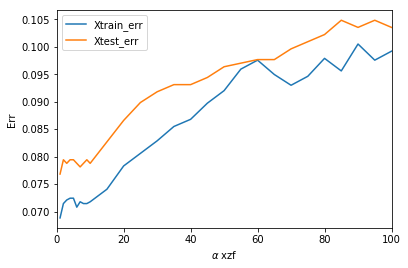

In [68]:
import matplotlib.pyplot as plt
x = np.arange(10)

plt.plot([i for i in lams], train_err_ls)
plt.plot([i for i in lams], test_err_ls)
plt.xlim(0,100)
plt.legend(['Xtrain_err', 'Xtest_err'], loc='upper left')
plt.xlabel('$\\alpha$ xzf')
plt.ylabel('Err')
plt.show()

###  What do you observe about the training and test errors as $\lambda$change?
As $\lambda$ increases, the training and test error are both tend to increase.

### Training and testing error rates for $\lambda$ = 1, 10 and 100.

In [69]:
print("Training error rates:")
print("\t \u03BB=1  ",train_err_ls[0])
print("\t \u03BB=10 ",train_err_ls[9])
print("\t \u03BB=100",train_err_ls[-1])
print("Testing error rates:")
print("\t \u03BB=1  ",test_err_ls[0])
print("\t \u03BB=10 ",test_err_ls[9])
print("\t \u03BB=100",test_err_ls[-1])

Training error rates:
	 λ=1   0.0688417618270799
	 λ=10  0.07177814029363783
	 λ=100 0.09918433931484505
Testing error rates:
	 λ=1   0.07682291666666663
	 λ=10  0.07877604166666663
	 λ=100 0.103515625
